# Project 02 - Out-of-Distribution Detection

Hello and Welcome to our second project this Semster: Out of Distribution Detection.

__Deadline__: 20.11.2023 @ 14:30

__Submission__: Please upload your finished notebooks here: https://fz-juelich.sciebo.de/s/qIKELa6d9RFYls0. The name of the notebook should contain the HHU-ID of every member in your group. If you have more than one file, please upload them zipped.


## Project
In the last lecture you learned about Variational Autoencoders (VAEs). They are a powerful extension to the standard autoencoders and we want to put them to the test. In the last project we did some MNIST image generation. This project consists of two parts. In the first part we want you to revisit the first project and replace the autoencoder with a VAE. In the second part of the project, we will look at a new dataset and the application of generative models to out-of-distribution detection.

## Part 1 - VAE:
### Data & Metrics
We will again use the higher resolution (28x28) MNIST dataset: https://www.openml.org/search?type=data&status=any&id=554. You can download it to your notebook using https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html.

The metrics remain the same as in the last project.

### Variational Autoencoder
We want to compare our previous autoencoder with a newly trained variational autoencoder. Change the current autoencoder implementation to a variational autoencoder. Use a special case of a variational autoencoder, the spatial variational autoencoder, where the latent space is not flattened but retains it's shape.

Repeat the experiments (quality, novelty, and interpolation) with our new VAE. Do we see an improvement?


## Part 2 - Out-of-Distribution Detection:
Now that we have a working implementation of a VAE, we move on to more complex datasets.
### Motivation
In our histological brain data, we want to analyze both cell distributions - such as density and size - as well as cytoarchitecture (higher level structures in the cells). However, a small percentage of our data is corrupted by various types of artifacts that prevent analysis. These artifacts cannot be avoided even with the most careful precautions.

![Example image of repaired artefacts](introduction.png "Example image of repaired artefacts")

We are currently working on deep learning models to fill in this corrupted data. But first we need to identify the affected locations. Supervised approaches with annotated data are not sufficient because artifacts do not share a common physiology. That is why we want to go the way of contratry. We should only know what uncorrupted data looks like, and determine artifacts by exclusion.
This approach is described in [Baur et al., 2018](https://arxiv.org/pdf/1804.04488.pdf).
To summarize the idea: Train a generative model on the task of reconstructing input images, but train it only on uncorrupted data. When applied to a corrupted sample, the model will not be able to reconstruct the artifact, resulting in a high reconstruction error.
In the paper, the authors train on whole brain slices (at a much lower resolution than our data), so we will only train on patches (256x256 may be good a size).

### Data
Our data set consists of thirty brain slices at 2 micron resolution. For each brain slice there is a tissue mask, this mask marks all tissue in the image - you should make sure that each training patch is at least 75% tissue. In addition, each section has an artifact mask that masks all artifacts in the brain - you should make sure that no training patch is sampled from these areas. Both masks are downsampled to 10 mircon. The data set is located in the same Sciebo folder.
Pre-compute your training patches, so you don't have to re-sample every training step.
You can look at the images using [FIJI](https://imagej.net/software/fiji/downloads), most normal image viewers can't handle large images.

### Model
In the paper the authors use the AnoVAEGAN, a combination of a VAE and a GAN. For now, you should only use a VAE. When we discuss GANs in class, we will adapt our model to incorporate ideas from the paper. Make sure you use a spatial VAE for better results (also use Batchnorm, ReLU and Dropout).

## Part 1 - VAE

1. Reload your models from project 01
2. Implement a spatial VAE, train it and recalculate the metrics.
3. Also try interpolation

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# torch imports
from tqdm.notebook import tqdm
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# Check if a GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(device)

cuda


In [5]:
# Define data transformation for MNIST dataset
transform = transforms.Compose([transforms.Resize((32, 32), antialias=True), transforms.ToTensor()])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Define batch size for DataLoader
batch_size = 512

# Create DataLoader for training and testing datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 112266657.43it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19273777.86it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27530976.40it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20957677.41it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



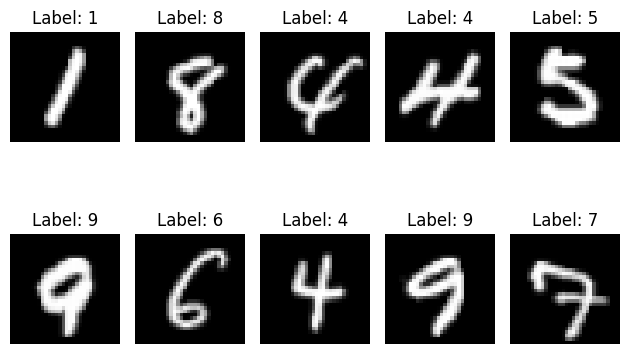

In [6]:
# Get a batch of data from the DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define the number of example images you want to display
num_examples = 10

# Iterate through the first `num_examples` images in the batch
for i in range(num_examples):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots
    plt.imshow(images[i].squeeze(), cmap='gray')  # Squeeze removes the batch dimension
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')  # Turn off axis labels

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

In [7]:
class Spatial_VAE(nn.Module):

    class EncoderBlock(nn.Module):
        def __init__(self, in_channels, out_channels = None, dropout = False, drop_p = 0.5, chnl_mult = 4):
            super().__init__()

            layers = nn.ModuleList()
            if out_channels is None:
                out_channels = in_channels*chnl_mult
            if dropout:
                layers.append(nn.Dropout(p = drop_p))
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding = 1, stride = 2))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU())

            self.block = nn.Sequential(*layers)

        def forward(self, x):
            return self.block(x)

    class DecoderBlock(nn.Module):
        def __init__(self, in_channels, out_channels = None, dropout = False, drop_p = 0.5, chnl_mult = 4):
            super().__init__()

            layers = nn.ModuleList()
            if out_channels is None:
                out_channels = in_channels//chnl_mult
            if dropout:
                layers.append(nn.Dropout(p = drop_p))
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding = 1))
            layers.append(nn.Upsample(scale_factor=2))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU())

            self.block = nn.Sequential(*layers)

        def forward(self, x):
            return self.block(x)

    def __init__(self, hid_dim = 10, init_size = 32, chnl_mult = 4, num_layers = 3):
        super().__init__()

        current_dim = 8
        final_size = round(init_size/(2**num_layers))
        # encoder
        encoder_layers = nn.ModuleList([
            nn.Conv2d(in_channels = 1, out_channels = current_dim, kernel_size=3, padding = 1),
            nn.LeakyReLU()])

        for i in range(num_layers):
            encoder_layers.append(self.EncoderBlock(current_dim, chnl_mult = chnl_mult))
            current_dim *= chnl_mult

        encoder_layers.extend([nn.Flatten(),
                               nn.Linear(final_size**2*current_dim, 2*hid_dim),
                               nn.Unflatten(1,(2, hid_dim))])
        self.encoder = nn.Sequential(*encoder_layers)


        #decoder
        decoder_layers = nn.ModuleList([nn.Linear(hid_dim, current_dim*final_size*final_size, bias=True),
                                        nn.Unflatten(1,(current_dim, final_size, final_size))])

        for i in range(num_layers):
            decoder_layers.append(self.DecoderBlock(current_dim, chnl_mult = chnl_mult))
            current_dim //= chnl_mult

        decoder_layers.extend([nn.Conv2d(in_channels=8, out_channels=1, kernel_size = 3, padding = 1),
                               nn.Sigmoid()
                               ])
        self.decoder = nn.Sequential(*decoder_layers)


    def transform(self, x):
        x = self.encoder(x)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
        else:
            sample = mu
        return sample

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def encode(self, x):
        mu, logsigma = self.transform(x)
        z = self.gaussian_sampler(mu, logsigma)
        return z, mu, logsigma

    def forward(self, x):
        z, mu, logsigma = self.encode(x)
        reconstruction = self.decode(z)
        return reconstruction, mu, logsigma

In [8]:
from torchsummary import summary
summary(Spatial_VAE(hid_dim=10, chnl_mult=4, num_layers=2), input_size=(1,32,32), device='cpu', batch_size=512)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [512, 8, 32, 32]              80
         LeakyReLU-2           [512, 8, 32, 32]               0
            Conv2d-3          [512, 32, 16, 16]           2,336
       BatchNorm2d-4          [512, 32, 16, 16]              64
         LeakyReLU-5          [512, 32, 16, 16]               0
      EncoderBlock-6          [512, 32, 16, 16]               0
            Conv2d-7           [512, 128, 8, 8]          36,992
       BatchNorm2d-8           [512, 128, 8, 8]             256
         LeakyReLU-9           [512, 128, 8, 8]               0
     EncoderBlock-10           [512, 128, 8, 8]               0
          Flatten-11                [512, 8192]               0
           Linear-12                  [512, 20]         163,860
        Unflatten-13               [512, 2, 10]               0
           Linear-14                [51

In [9]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def rec_loss(x, reconstruction):
    loss = nn.MSELoss(reduction = 'sum')
    return loss(reconstruction, x)

def loss_vae(x, reconstruction, mu, logsigma):
    return KL_divergence(mu, logsigma) + rec_loss(x, reconstruction)

In [10]:
def train_epoch(model, criterion, optimizer, train_loader):
    model.train()
    train_loss = 0.0
    for inputs, labels in tqdm(train_loader, leave = False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        if isinstance(criterion, nn.CrossEntropyLoss):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        else:
            outputs, mu, logsigma = model(inputs)
            loss = criterion(inputs, outputs, mu, logsigma)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    return train_loss

def validate(model, criterion, test_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if isinstance(criterion, nn.CrossEntropyLoss):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            else:
                outputs, mu, logsigma = model(inputs)
                loss = criterion(inputs, outputs, mu, logsigma)
            val_loss += loss.item()

    val_loss = val_loss / len(test_loader)
    return val_loss

# Training function
def train(model, criterion, optimizer, train_loader, test_loader, num_epochs):
    # Lists to store training and validation loss for plotting
    train_loss_history = []
    val_loss_history = []
    # Initialize the plot
    fig, ax = plt.subplots(1, 1, figsize = (10,5))
    fig.patch.set_facecolor('white')
    dh = display(fig, display_id=True)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')

    for epoch in tqdm(range(num_epochs)):
        #Training loop
        train_loss = train_epoch(model, criterion, optimizer, train_loader)
        train_loss_history.append(train_loss)
        # Validation loop
        val_loss = validate(model, criterion, test_loader)
        val_loss_history.append(val_loss)

        # print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        # Update the plot data
        ax.cla()

        line1, = ax.plot(train_loss_history, c = 'r', label = 'Train')
        line2, = ax.plot(val_loss_history, c = 'b', label = 'Val')
        ax.legend(handles=[line1, line2])
        dh.update(fig)
    plt.close()


    return train_loss_history, val_loss_history

In [11]:
# Define the number of training epochs and lr
num_epochs = 10
learning_rate = 5e-4

# Define model, loss and optimizer
model_vae = Spatial_VAE(hid_dim=32, chnl_mult=4, num_layers=3).to(device)
criterion = loss_vae
optimizer = optim.AdamW(model_vae.parameters(), lr=learning_rate)

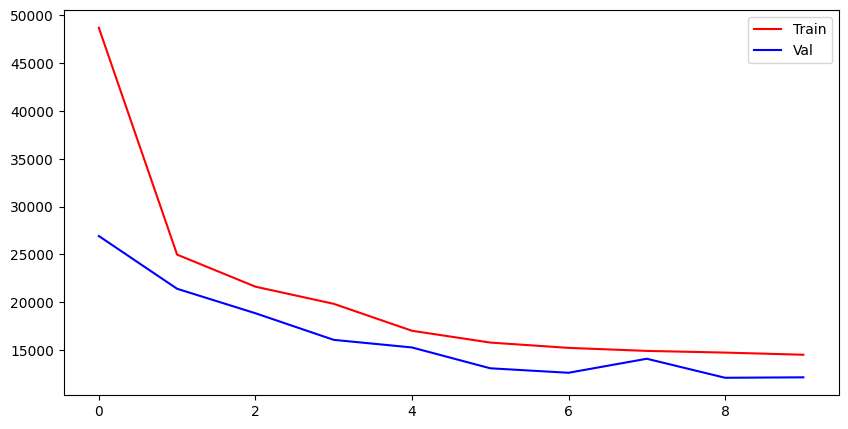

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

In [12]:
train_loss_history, val_loss_history = train(model_vae, criterion, optimizer, train_loader, test_loader, num_epochs)

In [36]:
torch.save(model_vae.state_dict(), 'spatial_vae_w.pt')

In [14]:
model_vae.load_state_dict(torch.load('spatial_vae_w.pt'))
model_vae.eval()
pass

In [15]:
def reconstruct_vae(model, data):
  model.eval()
  with torch.no_grad():
      for batch, label in data:
        reconstruction, _, _,  = model(batch.to(device))
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch.numpy()
        break

  plt.figure(figsize=(18, 6))
  for i, (gt, res) in enumerate(zip(ground_truth[6:12], result[6:12])):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.squeeze(gt,0), cmap='gray')
    plt.title('Original')
    plt.axis('off')
    plt.subplot(2, 6, i+7)
    plt.imshow(np.squeeze(res,0), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

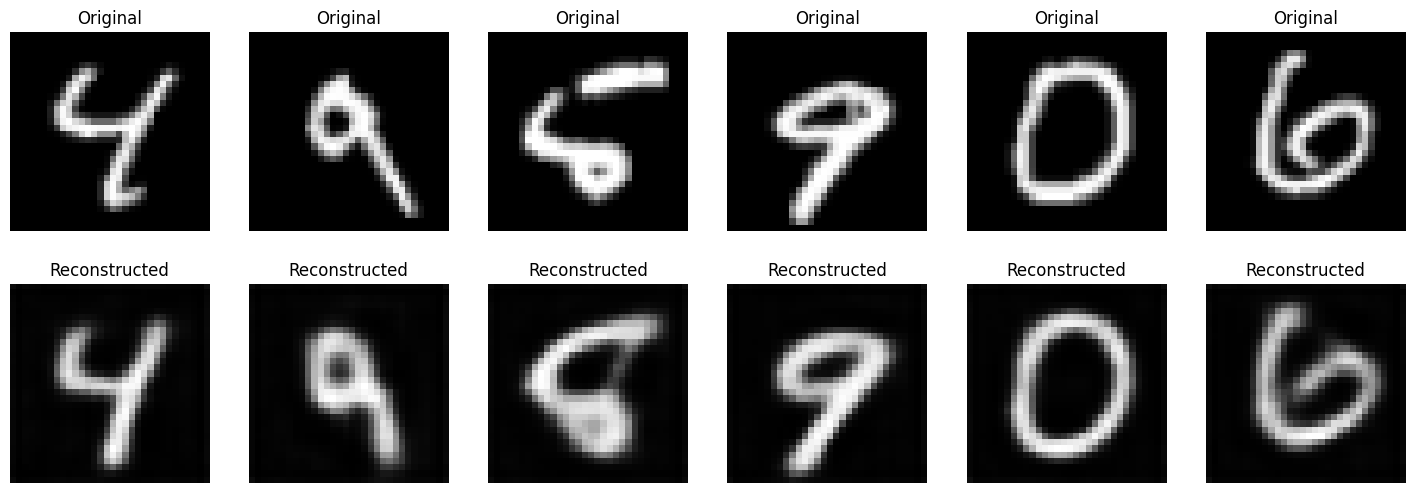

In [16]:
reconstruct_vae(model_vae, test_loader)

### Metrics

In [27]:
class Classifier(nn.Module):
    def __init__(self, model_ae, latent_size=32, num_class=10):
        super().__init__()
        self.encoder = model_ae
        self.classifier_head = nn.Linear(latent_size, num_class)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        z, _, _ = self.encoder.encode(x)
        return self.classifier_head(z)

    def classify(self, x):
        with torch.no_grad():
            return np.argmax(self.softmax(self(x)).cpu().numpy(), axis=1)

In [28]:
import torch.nn as nn
import torch.optim as optim

# Define the number of training epochs and lr
num_epochs = 5
learning_rate = 0.001

# Define model, loss and optimizer
model_classifier = Classifier(model_vae).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_classifier.parameters(), lr=learning_rate)

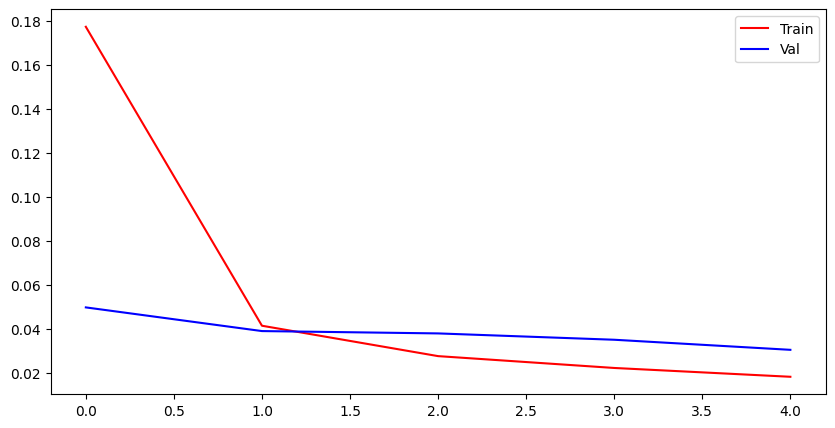

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

In [29]:
# Call the training function
train_loss_history, val_loss_history = train(model_classifier, criterion, optimizer, train_loader, test_loader, num_epochs)

In [37]:
torch.save(model_classifier.state_dict(), 'classifier_w.pt')

In [31]:
model_classifier.load_state_dict(torch.load('classifier_w.pt'))
model_classifier.eval()
pass

In [32]:
def test_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predicted = torch.tensor(model.classify(inputs)).to(device)
            total += labels.size(0)
            correct += (predicted == labels).float().sum().item()

    accuracy = correct / total
    return accuracy*100

# Usage:
test_acc = test_accuracy(model_classifier, test_loader, device)
print(f'Test Accuracy: {test_acc:.2f} %')


Test Accuracy: 99.04 %


In [33]:
def quality_metric(model, images):
    with torch.no_grad():
      pred = torch.softmax(model(images.to(device)), dim = 1) # tensors?
    max_prob = torch.max(pred, dim=1).values
    return torch.mean(max_prob)

def get_latents(model, train_loader):
  model.eval()
  latent_representations_train = []
  with torch.no_grad():
    for train_data, _ in tqdm(train_loader, leave = False):
      train_data = train_data.to(device)
      z, _, _ = model.encode(train_data)
      latent_representations_train.append(z)
    latent_representations_train = torch.cat(latent_representations_train, dim = 0)
  return latent_representations_train.cpu()

# Evaluate the model
def novelty_metric(model, images, train_representations):
  with torch.no_grad():
    z, _, _ = model.encode(images.to(device))
    z = z.cpu()
  distances = torch.min(torch.cdist(z, train_representations, p = 2), dim = 1).values

  novelty_scores = distances/(distances.max() + 1e-8)

  return novelty_scores.mean()

latent_representations_train = get_latents(model_vae, train_loader)

  0%|          | 0/118 [00:00<?, ?it/s]

In [34]:
num_examples = 1000
with torch.no_grad():
    samples = model_vae.decode(torch.randn((num_examples , 32), device=device)).detach()
quality = quality_metric(model_classifier, samples)
novelty = novelty_metric(model_vae, samples, latent_representations_train)
print(f'Quality metric: {quality.item()}, Novelty metric: {novelty.item()}')

Quality metric: 0.9009236097335815, Novelty metric: 0.448501855134964


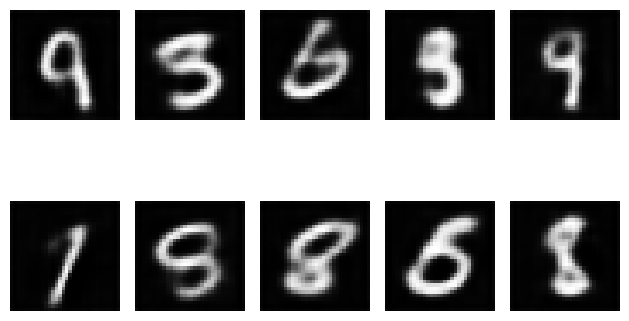

In [35]:
torch.cuda.empty_cache()

#Plotting generated samples

# Define the number of example images you want to display
num_examples = 10
# samples = sample_kde(latent_representations_train, bandwidth, model_vae).cpu()
samples = model_vae.decode(torch.randn((num_examples , 32), device=device)).detach().cpu().numpy()

# Iterate through the first `num_examples` images in the batch
for i in range(num_examples):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots
    plt.imshow(samples[i].squeeze(), cmap='gray')  # Squeeze removes the batch dimension
    # plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')  # Turn off axis labels

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

### Interpolation

In [50]:
# Get a batch of data from the DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)
with torch.no_grad():
    latent_vectors, _, _ = model_vae.encode(images[:2].to(device))
# Define the number of example images you want to display
N = 10
# Interpolate
A, B = latent_vectors[0], latent_vectors[1]
C = B - A
interpolated_vectors = [A + i*C for i in np.linspace(0, 1, N)]
interpolated_imgs = [model_vae.decode(vector[None, ...]).detach().cpu() for vector in interpolated_vectors]

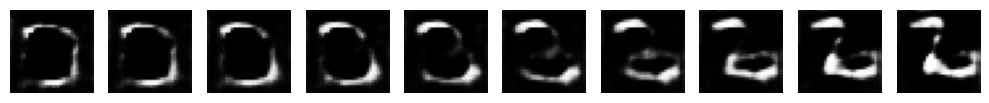

In [51]:
# Plot interpolated images
plt.figure(figsize=(10, 5))

for i in range(N):
    plt.subplot(1, N, i + 1)  # Create a 2x5 grid of subplots
    plt.imshow(interpolated_imgs[i].squeeze(), cmap='gray')  # Squeeze removes the batch dimension
    plt.axis('off')  # Turn off axis labels

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

## Part 2 - Out-of-Distribution Detection

1. Write a dataloader for the images. Pre-compute your patches, so you don't have to sample @ every training step.
2. Use your implementation from above to train a VAE on this data.
3. Investigate your model, sample from it. Look at interpolation.
4. Apply your model to image patches with artefacts, does it perform worse there? Can we use the reconstruction error as an indicator for artefacts?

### Dataset

In [68]:
from sklearn.model_selection import train_test_split

class BTiss_Dataset(Dataset):
    def __init__(self, image_folder, mask_folder, artifact_folder, split ='train', step = 256, patch_size=256, transform=None, recalculate = True):
        self.image_folder = image_folder
        self.transform = transform
        self.patch_size = patch_size
        self.split = split
        if recalculate:
            data = self.get_patches(image_folder, mask_folder, artifact_folder, step = step, patch_size = patch_size)
        else:
            data = [os.path.join('image_patches', filename) for filename in os.listdir('image_patches')]
        self.artifacts = [os.path.join('artifact_patches', filename) for filename in os.listdir('artifact_patches')]
        self.train_data, self.val_data = train_test_split(data, test_size=0.1, random_state=42, shuffle = True)

    def __len__(self):
        if self.split == 'train':
            return len(self.train_data)
        elif self.split == 'artifacts':
            return len(self.artifacts)
        else:
            return len(self.val_data)

    def __getitem__(self, idx):
        if self.split == 'train':
            image_path = self.train_data[idx]
        elif self.split == 'artifacts':
            image_path = self.artifacts[idx]
        else:
            image_path = self.val_data[idx]

        # Read image
        patch = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

        # Apply transformations
        if self.transform:
            patch = self.transform(patch)

        return patch, 0

    def get_patches(self, image_folder, mask_folder, artifact_folder, step = 16, patch_size=256, tissue_ratio=0.75):
        patches = []
        os.makedirs('image_patches', exist_ok=True)
        os.makedirs('artifact_patches', exist_ok=True)
        count = 0

        for filename in tqdm(os.listdir(image_folder)):
            if filename.endswith('.tif'):  # assuming images are in .tif format
                base_filename = filename[:-4]  # remove .tif extension

                # Load the image and corresponding masks
                image_np = cv2.imread(os.path.join(image_folder, filename), cv2.IMREAD_UNCHANGED)
                mask_np = cv2.imread(os.path.join(mask_folder, base_filename + '_mask.tif'), cv2.IMREAD_UNCHANGED)
                artifact_mask_np = 255 - cv2.imread(os.path.join(artifact_folder, base_filename + '_artifact_mask.tif'), cv2.IMREAD_UNCHANGED)

                #resize masks to fit the original image and overwrite them with resized versions
                if image_np.shape[1] != mask_np.shape[1]:
                    mask_np = cv2.resize(mask_np, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_AREA)
                    cv2.imwrite(os.path.join(mask_folder, base_filename + '_mask.tif'), mask_np)
                    artifact_mask_np = cv2.resize(artifact_mask_np, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_AREA)
                    cv2.imwrite(os.path.join(artifact_folder, base_filename + '_artifact_mask.tif'), artifact_mask_np)
                # Slide a window over the image
                for i in tqdm(range(0, image_np.shape[0] - patch_size, step), leave = False):
                    for j in range(0, image_np.shape[1] - patch_size, step):
                        # Extract patch from mask
                        mask_patch = mask_np[i:i+patch_size, j:j+patch_size]

                        # Check if patch contains at least 75% tissue
                        if np.sum(mask_patch > 0) / (patch_size * patch_size) >= tissue_ratio:
                            # Extract corresponding patch from artifact mask
                            artifact_patch = artifact_mask_np[i:i+patch_size, j:j+patch_size]
                            img_patch = image_np[i:i+patch_size, j:j+patch_size]

                            # Check if patch contains no artifacts
                            if np.sum(artifact_patch) == 0:
                                # If conditions are met, add patch coordinates to list
                                save_path = os.path.join('image_patches', base_filename+f'_{count}'+'.png')
                                cv2.imwrite(save_path, img_patch)
                                patches.append(save_path)
                                count+=1
                            else:
                              save_path = os.path.join('artifact_patches', base_filename+f'_{count}'+'.png')
                              cv2.imwrite(save_path, img_patch)
                              count+=1

            # break

        return patches

In [69]:
# Define transformations, you can add more if needed
data_transform = transforms.Compose([
    transforms.ToTensor(),
    # Add more transformations as needed
])

# Create an instance of the dataset

image_folder = 'image_data_low_scale'
mask_folder = 'mask_data'
artifact_folder = 'artifact_mask_data'

train_dataset = BTiss_Dataset(image_folder, mask_folder, artifact_folder, step=128, transform=data_transform, recalculate=False)
val_dataset = BTiss_Dataset(image_folder, mask_folder, artifact_folder, split = 'val', step=128, transform=data_transform, recalculate=False)
art_dataset = BTiss_Dataset(image_folder, mask_folder, artifact_folder, split = 'artifacts', step=128, transform=data_transform, recalculate=False)

In [70]:
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
art_loader = DataLoader(dataset=art_dataset, batch_size=batch_size)

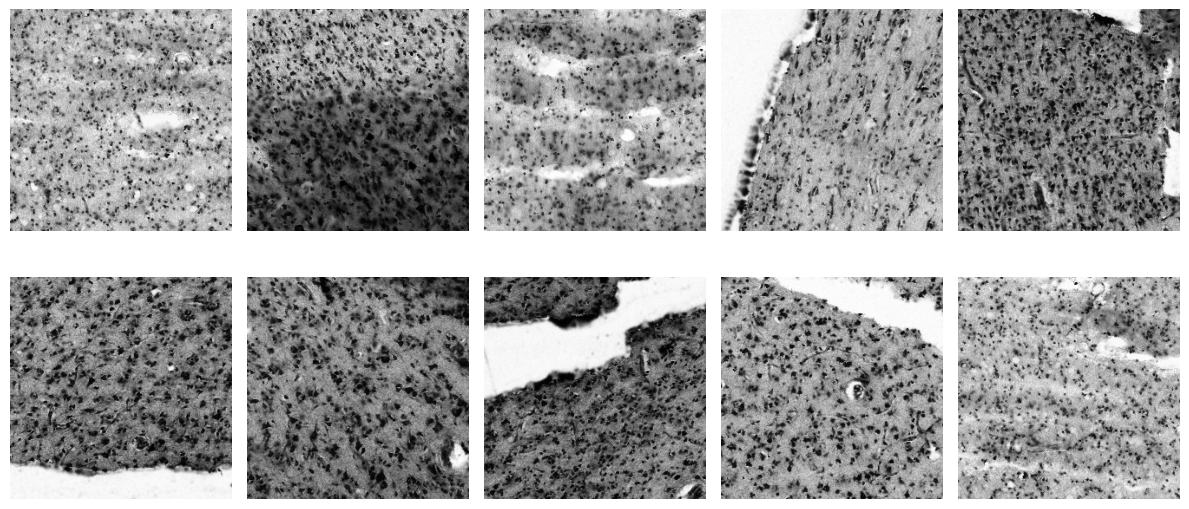

In [55]:
# Define the number of example images you want to display
num_examples = 10
# Get a batch of data from the DataLoader
dataiter = iter(train_loader)
images, _ = next(dataiter)


plt.figure(figsize=(12, 6))
# Iterate through the first `num_examples` images in the batch
for i in range(num_examples):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots
    plt.imshow(images[i].squeeze(), cmap='gray')  # Squeeze removes the batch dimension
    plt.axis('off')  # Turn off axis labels

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

In [56]:
summary(Spatial_VAE(2048, init_size=256, chnl_mult=2, num_layers=3), input_size=(1,256,256), device='cpu', batch_size = 32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 8, 256, 256]              80
         LeakyReLU-2          [32, 8, 256, 256]               0
            Conv2d-3         [32, 16, 128, 128]           1,168
       BatchNorm2d-4         [32, 16, 128, 128]              32
         LeakyReLU-5         [32, 16, 128, 128]               0
      EncoderBlock-6         [32, 16, 128, 128]               0
            Conv2d-7           [32, 32, 64, 64]           4,640
       BatchNorm2d-8           [32, 32, 64, 64]              64
         LeakyReLU-9           [32, 32, 64, 64]               0
     EncoderBlock-10           [32, 32, 64, 64]               0
           Conv2d-11           [32, 64, 32, 32]          18,496
      BatchNorm2d-12           [32, 64, 32, 32]             128
        LeakyReLU-13           [32, 64, 32, 32]               0
     EncoderBlock-14           [32, 64,

### Training

In [57]:
# Define the number of training epochs and lr
num_epochs = 40
learning_rate = 5e-4

# Define model, loss and optimizer
model_vae = Spatial_VAE(2048, init_size=256, chnl_mult=2, num_layers=3).to(device)
criterion = loss_vae
optimizer = optim.AdamW(model_vae.parameters(), lr=learning_rate)

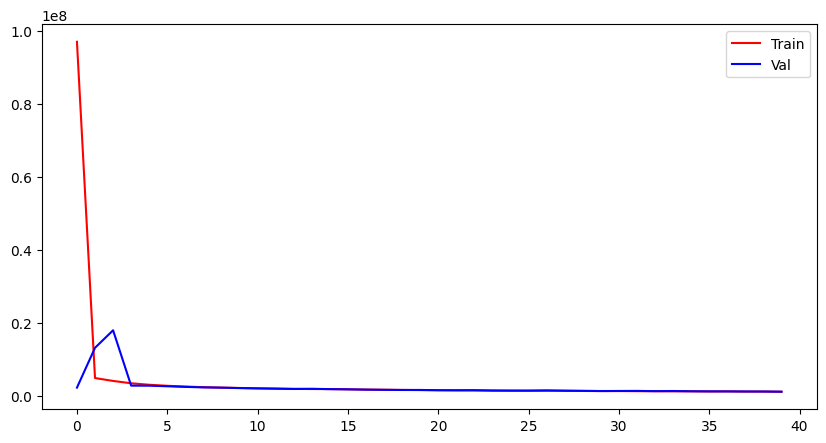

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [58]:
train_loss_history, val_loss_history = train(model_vae, criterion, optimizer, train_loader, val_loader, num_epochs)

### Reconstruction

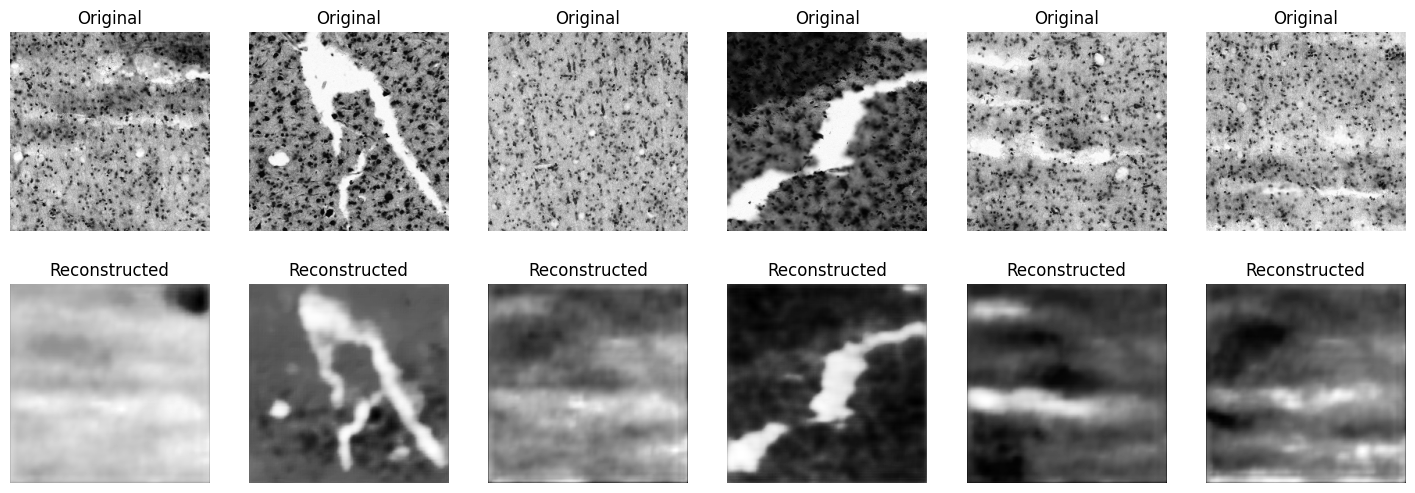

In [59]:
reconstruct_vae(model_vae, train_loader)

In [60]:
torch.save(model_vae.state_dict(), 'spatial_vae_bt.pt')

In [61]:
model_vae.load_state_dict(torch.load('spatial_vae_bt.pt'))
model_vae.eval()
pass

### Sampling

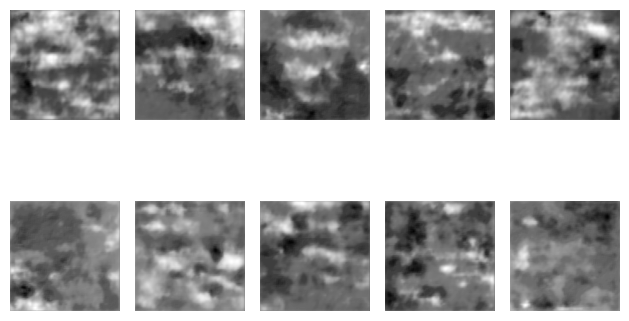

In [63]:
torch.cuda.empty_cache()

#Plotting generated samples

# Define the number of example images you want to display
num_examples = 10
# samples = sample_kde(latent_representations_train, bandwidth, model_vae).cpu()
samples = model_vae.decode(torch.randn((num_examples , 2048), device=device)).detach().cpu().numpy()

# Iterate through the first `num_examples` images in the batch
for i in range(num_examples):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots
    plt.imshow(samples[i].squeeze(), cmap='gray')  # Squeeze removes the batch dimension
    # plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')  # Turn off axis labels

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

In [71]:
latent_representations_train = get_latents(model_vae, train_loader)
latent_representations_art = get_latents(model_vae, art_loader)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

### TSNE

In [74]:
border = len(latent_representations_train)
latent_representations = torch.cat([latent_representations_train, latent_representations_art], dim = 0)
latent_representations.shape

torch.Size([2424, 2048])

In [76]:
from sklearn.manifold import TSNE

latents_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(latent_representations)

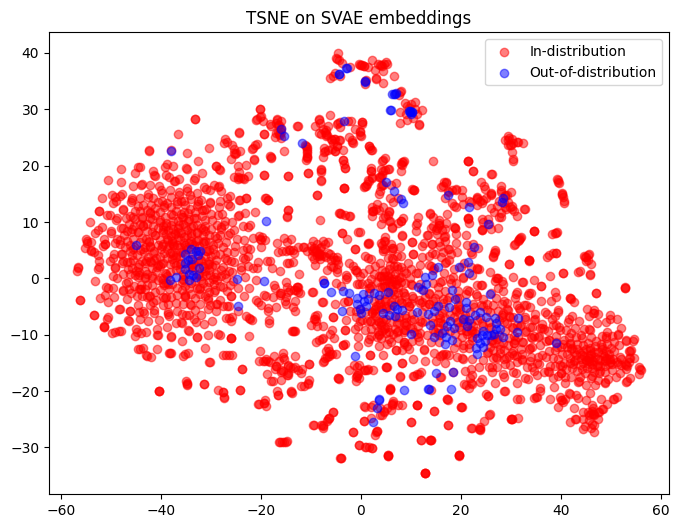

In [78]:
# Plot the TSNE result
plt.figure(figsize=(8, 6))
plt.scatter(latents_embedded[: border, 0], latents_embedded[: border, 1], label='In-distribution', alpha=0.5, c = 'r')
plt.scatter(latents_embedded[border:, 0], latents_embedded[border:, 1], label='Out-of-distribution', alpha=0.5, c = 'b')
plt.legend()
plt.title('TSNE on SVAE embeddings')
plt.show()

Seems like using VAE for OOD detection in this case is not possible.

### Interpolation

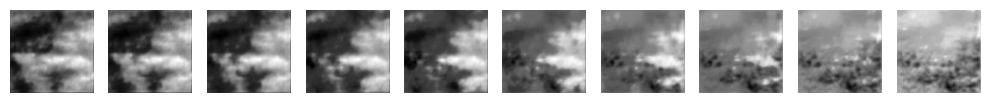

In [79]:
# Get a batch of data from the DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)
with torch.no_grad():
    latent_vectors, _, _ = model_vae.encode(images[:2].to(device))
# Define the number of example images you want to display
N = 10
# Interpolate
A, B = latent_vectors[0], latent_vectors[1]
C = B - A
interpolated_vectors = [A + i*C for i in np.linspace(0, 1, N)]
interpolated_imgs = [model_vae.decode(vector[None, ...]).detach().cpu() for vector in interpolated_vectors]

# Plot interpolated images
plt.figure(figsize=(10, 5))

for i in range(N):
    plt.subplot(1, N, i + 1)  # Create a 2x5 grid of subplots
    plt.imshow(interpolated_imgs[i].squeeze(), cmap='gray')  # Squeeze removes the batch dimension
    plt.axis('off')  # Turn off axis labels

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

## Feedback

* __Length__: OK
* __Difficulty__: OK
* __Guidance__: In our opinion, the part about Spatial VAE architecture should have been communicated better (a detailed description or at least the specific paper that you had in mind), especially since words "where the latent space is not flattened but retains it's shape" from the project's description contradict what is written in many papers on this subject. 
Also it would be great to know in some capacity (e.g. example pictures) what are the expected results, because it's truly difficult to understand if you did a mistake and that's the reason for the bad output of your model, or it is actually supposed to be like that due to limitations of the proposed approach.